# Predict fradulent money transactions

**objective**
- Preprocess the data ready for fitting ML models
- Apply different algorithms to generate better prediction on frauds

In [101]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_context(rc = {'patch.linewidth': 0.0})
sns.set_palette('Set2')

SMALL_SIZE = 13
MEDIUM_SIZE = SMALL_SIZE + 6

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)   # fontsize of the axes title\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize\n",
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title\n",
plt.rc('figure', dpi=150)

In [2]:
paysim = pd.read_csv("../data/paysim_for_ML.csv", index_col=0)
print(paysim.shape)
paysim.head()

/home/hyoj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(6362620, 12)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,validTransactionType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CB
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CB
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CB


# Feature engineering

To fit into a logistic regression model, we need all the features to be numeric

In [3]:
# Find transactions type which are possibly fraud: transfer or cashout
type_filter = (paysim['type'] == 'TRANSFER')|(paysim['type'] == 'CASH_OUT')

# Flag the rows only if their transaction types were either transfer or cashout
paysim['type_to_watch']=type_filter*1

In [4]:
# Let's map 'type' info into numeric values
paysim['type'] = paysim['type'].map({'PAYMENT':0, 'TRANSFER':1, 'CASH_OUT':2, 'DEBIT':3, 'CASH_IN':4})
paysim['type'].value_counts()

2    2237500
0    2151495
4    1399284
1     532909
3      41432
Name: type, dtype: int64

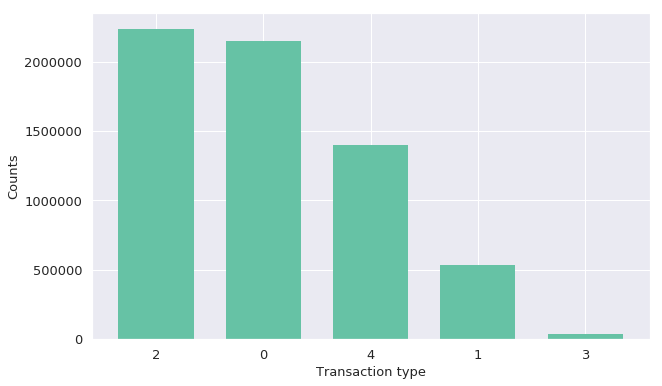

In [5]:
fig10 = plt.figure(figsize=(10,6))
paysim['type'].value_counts().plot(kind='bar', width=.7, rot=0)
plt.ylabel('Counts')
plt.xlabel('Transaction type')
fig10.savefig('./Fig10.png', dpi=200)

In [6]:
# Convert 'validTransactionType' into numeric values

paysim['validTransactionType'] = paysim['validTransactionType'].map({'CC':1, 'CB':2, 'BB':3, 'BC':4})
paysim['validTransactionType'].value_counts()

1    4211125
2    2151495
Name: validTransactionType, dtype: int64

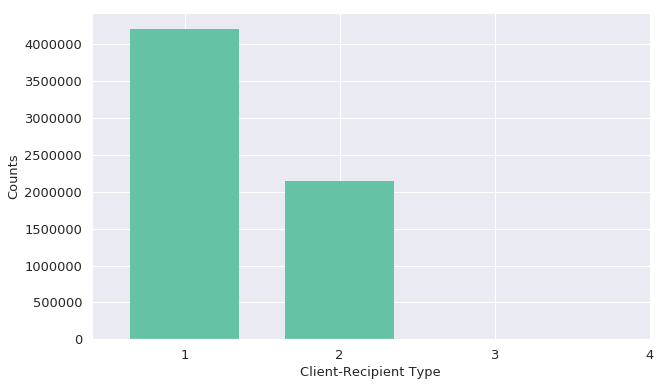

In [7]:
fig11= plt.figure(figsize=(10,6))
paysim['validTransactionType'].value_counts().plot(kind='bar', width=.7, rot=0)
plt.ylabel('Counts')
plt.xlabel('Client-Recipient Type')
plt.xticks([0, 1, 2, 3], [1, 2, 3, 4])
fig11.savefig('./Fig11.png', dpi=200)

In [8]:
# The target is highly unblanced:

paysim['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
# Final features

features = [col for col in paysim.columns if col not in ['isFraud', 'nameOrig', 'nameDest']]
features

['step',
 'type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud',
 'validTransactionType',
 'type_to_watch']

# Modeling

# Prepare train and test sets to build predictive models

In [11]:
# Import libraries to split the data
from sklearn.model_selection import train_test_split

In [12]:
# Define features and the target
X = paysim[features]
y = paysim['isFraud']

# train_test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3)

In [13]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4453834 4453834
1908786 1908786


* Models to apply:
    1. Logistic regression
    2. Neural network
    3. Random forest
    4. XGBoost

## Build a baseline

In [14]:
# Use a logistic function (sigmoidal function) for a classic binary classification problem,
# in which the prediction input is a probability value between 0 and 1.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, roc_auc_score, roc_curve, recall_score, classification_report

## Data standardization

When implementing a logistic regression, standardizing the data to rescale all variables into a relatively similar range will result in similar distribution of standard deviation from the mean equals one.
<br>
<br>
Among various standardization techniques available in scikit-learn (e.g. MinMaxScaler, RobustScaler, Normalizer), we'll adopt StandardScaler so that all features can have same mean and unit variance.

In [15]:
# Import standardization method: StandardScaler
from sklearn.preprocessing import StandardScaler

In [16]:
# Initiate standard scaler
scaler = StandardScaler()

# Fit and transform the features from both train and test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4453834 4453834
1908786 1908786


In [27]:
logistic = LogisticRegression()
result = logistic.fit(X_train, y_train)

y_prediction_base = logistic.predict(X_test)

/home/hyoj/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<Figure size 720x720 with 0 Axes>

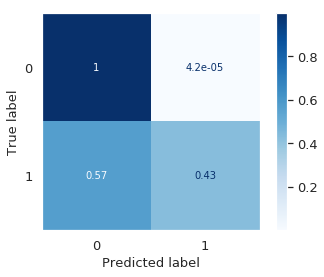

In [28]:
# Plot a confusion matrix using test sets
plt.figure(figsize=(10,10))
confusion_matrix = plot_confusion_matrix(logistic, X_test, y_test, cmap='Blues', normalize='true')
plt.grid(False)

Recall score: 0.4315832988838363


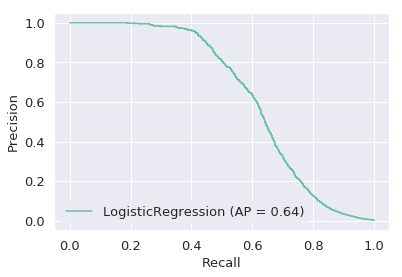

In [29]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)

recall_base = recall_score(y_test, y_prediction_base)
print(f'Recall score: {recall_base}')

base_precision_recall = plot_precision_recall_curve(logistic, X_test, y_test)
base_precision_recall

Area Under Curve: 0.7157704048442094


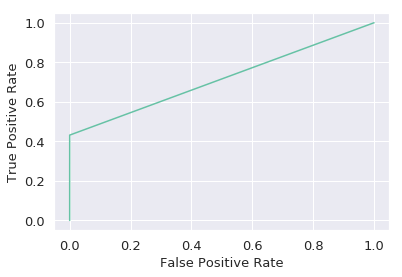

In [30]:
# Plot roc_curve
print(f'Area Under Curve: {roc_auc_score(y_test, y_prediction_base)}')

fpr_base, tpr_base, _ = roc_curve(y_test, y_prediction_base)

plt.plot(fpr_base, tpr_base, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [31]:
print(classification_report(y_test, y_prediction_base))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       0.93      0.43      0.59      2419

    accuracy                           1.00   1908786
   macro avg       0.96      0.72      0.79   1908786
weighted avg       1.00      1.00      1.00   1908786



*Note:
Low recall rate due to highly unbalanced target
Let's impose different weights on target and compensate the imbalance

In [36]:
# Proportion of target values
y.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

# Improve the model:

    1. Use different ML algorithms: logistic regression, neural network, random forest, XGBoost
    2. Penalize wrong predictions by imposing different weights on each class

## A. Logistic regression

### + Hyperparameter adjustment: Class weight

The ratio of not_fraud(0) vs. fraud(1) is almost 99.9 vs. 0.1 (%)
Therefore, by defining the class weights as inverse of label distribution, we can penalize the wrong prediction of the minorities much higher than that of the majorities.
To this end, we implement 'class_weight' hyperparameter of Logistic regression.

In [37]:
# Define class weights
weight = {0:0.1, 1:99.9}

In [38]:
# Fit agian with logistic regression
logistic2 = LogisticRegression(class_weight=weight)
logistic2.fit(X_train, y_train)

y_prediction_logistic = logistic2.predict(X_test)

/home/hyoj/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


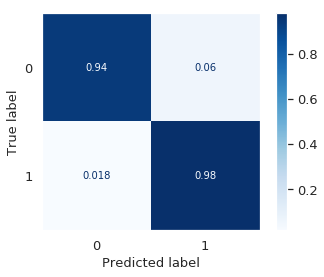

In [39]:
# Plot a confusion matrix using test sets
plot_confusion_matrix(logistic2, X_test, y_test, cmap='Blues', normalize='true')
plt.grid(False)

Recall score: 0.981686541737649


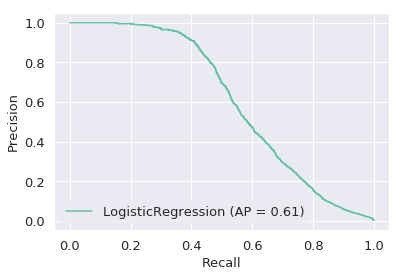

In [45]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)
recall_logistic = recall_score(y_test, y_prediction_logistic)
print(f'Recall score: {recall_logistic}')

logistic_precision_recall = plot_precision_recall_curve(logistic2, X_test, y_test)
plt.show()

Area Under Curve: 0.9610232609865205


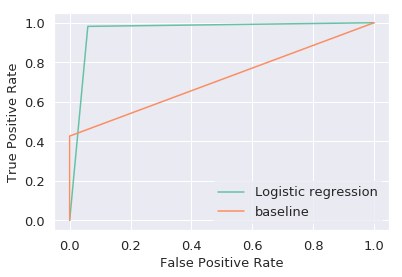

In [40]:
# Plot roc_curve
print(f'Area Under Curve: {roc_auc_score(y_test, y_prediction_logistic)}')

fpr, tpr, _ = roc_curve(y_test, y_prediction_logistic)

plt.plot(fpr, tpr, label='Logistic regression')
plt.plot(fpr_base, tpr_base, label='baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [42]:
print(classification_report(y_test, y_prediction_logistic))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906438
           1       0.02      0.98      0.04      2348

    accuracy                           0.94   1908786
   macro avg       0.51      0.96      0.50   1908786
weighted avg       1.00      0.94      0.97   1908786



Note:
- Recall score improved: Successfully reduced FNs but increased FPs
- Area under curve score increased



## B. Neural network

In [18]:
# Import libraries to build and evaluate the model
from tensorflow.keras import Sequential, layers, optimizers, metrics

In [19]:
# Layers
nn_layers = [
            layers.Dense(24, activation='relu', input_shape=(10,)), # 10 features
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(1, activation='sigmoid') # 1 output
            ]

# Creating a sequential model
nn_model = Sequential(nn_layers)

In [20]:
# Recompile and train
nn_model.compile(optimizer='Adam',
                 loss='binary_crossentropy',
                 metrics=[metrics.AUC(), metrics.Recall()])

# Class weight hyperparameter not applied
history = nn_model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
139183/139183 [==============================] - 278s 2ms/step - loss: 0.0040 - auc: 0.9116 - recall: 0.5155 - val_loss: 0.0030 - val_auc: 0.9639 - val_recall: 0.5444
Epoch 2/8
139183/139183 [==============================] - 265s 2ms/step - loss: 0.0035 - auc: 0.9378 - recall: 0.5906 - val_loss: 0.0025 - val_auc: 0.9373 - val_recall: 0.6292
Epoch 3/8
139183/139183 [==============================] - 220s 2ms/step - loss: 0.0032 - auc: 0.9461 - recall: 0.6063 - val_loss: 0.0055 - val_auc: 0.9440 - val_recall: 0.6015
Epoch 4/8
139183/139183 [==============================] - 242s 2ms/step - loss: 0.0035 - auc: 0.9509 - recall: 0.6260 - val_loss: 0.0025 - val_auc: 0.9555 - val_recall: 0.6176
Epoch 5/8
139183/139183 [==============================] - 269s 2ms/step - loss: 0.0034 - auc: 0.9527 - recall: 0.6336 - val_loss: 0.0023 - val_auc: 0.9672 - val_recall: 0.6279
Epoch 6/8
139183/139183 [==============================] - 284s 2ms/step - loss: 0.0047 - auc: 0.9570 - recall: 0.6

In [21]:
print(history.history)

{'loss': [0.004018762148916721, 0.003472004784271121, 0.003177057718858123, 0.003480842337012291, 0.003427782328799367, 0.004718975629657507, 0.0031660140957683325, 0.003988030832260847], 'auc': [0.9116451740264893, 0.9378161430358887, 0.946101188659668, 0.9508901834487915, 0.9526853561401367, 0.9570019245147705, 0.9593774676322937, 0.9603978395462036], 'recall': [0.5155333280563354, 0.5906109809875488, 0.606316864490509, 0.6259924173355103, 0.6335864663124084, 0.6479116082191467, 0.6513634920120239, 0.6551604866981506], 'val_loss': [0.002965811174362898, 0.0025139381177723408, 0.005531083792448044, 0.0025218285154551268, 0.002318123122677207, 0.00232179113663733, 0.003380236914381385, 0.0023884533438831568], 'val_auc': [0.9638708233833313, 0.9372913837432861, 0.9440128207206726, 0.9554528594017029, 0.9671873450279236, 0.9814450144767761, 0.9266742467880249, 0.9551765322685242], 'val_recall': [0.5444398522377014, 0.6291856169700623, 0.6014882326126099, 0.6176105737686157, 0.62794542312

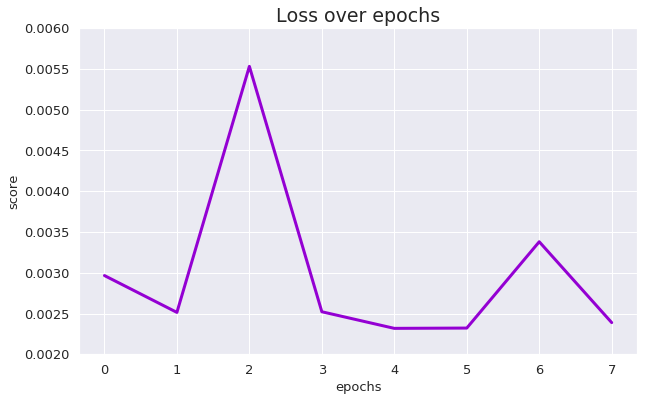

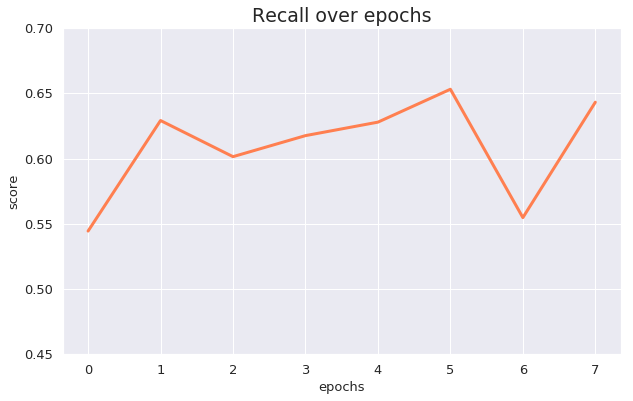

In [97]:
# Loss plot
fig_loss_1 = plt.figure(figsize=(10,6))
plt.plot(history.history['val_loss'], linewidth=3, label='loss', color='darkviolet')
plt.title('Loss over epochs')
plt.ylim(0.0020, 0.0060)
plt.ylabel('score')
plt.xlabel('epochs')

plt.show()
fig_loss_1.savefig('./nn_1_loss.png', dpi=200)

# Recall plot
fig_recall_1 = plt.figure(figsize=(10,6))
plt.plot(history.history['val_recall'], linewidth=3, label='recall', color='coral')
plt.title('Recall over epochs')
plt.ylabel('score')
plt.ylim(0.45, 0.70)
plt.xlabel('epochs')
plt.show()
fig_recall_1.savefig('./nn_1_recall.png', dpi=200)

In [51]:
# Generate predicted y values
y_prediction_nn = nn_model.predict(X_test)

Area Under Curve: 0.9943717957234752


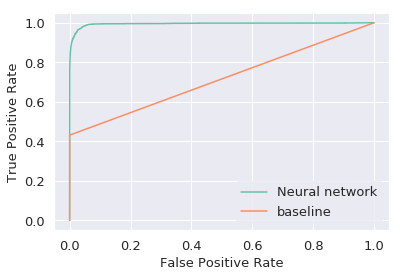

In [35]:
# Print the auc score
print(f'Area Under Curve: {roc_auc_score(y_test, y_prediction_nn)}')

# Plot roc_curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prediction_nn)

plt.plot(fpr_nn, tpr_nn, label='Neural network')
plt.plot(fpr_base, tpr_base, label='baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Second NN

In [58]:
# Layers
nn_layers_2 = [
            layers.Dense(16, activation='relu', input_shape=(10,)), # 10 features
            layers.Dense(8, activation='relu'),
            layers.Dense(1, activation='sigmoid') # 1 output
            ]

# Creating a sequential model
nn_model_2 = Sequential(nn_layers_2)

In [59]:
# Recompile and train
nn_model_2.compile(optimizer='Adam',
                 loss='binary_crossentropy',
                 metrics=[metrics.Recall()])

# Class weight hyperparameter not applied
history_2 = nn_model_2.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
139183/139183 [==============================] - 258s 2ms/step - loss: 0.0043 - recall_1: 0.4337 - val_loss: 0.0036 - val_recall_1: 0.4944
Epoch 2/8
139183/139183 [==============================] - 256s 2ms/step - loss: 0.0031 - recall_1: 0.5744 - val_loss: 0.0026 - val_recall_1: 0.5986
Epoch 3/8
139183/139183 [==============================] - 216s 2ms/step - loss: 0.0028 - recall_1: 0.6063 - val_loss: 0.0025 - val_recall_1: 0.6428
Epoch 4/8
139183/139183 [==============================] - 212s 2ms/step - loss: 0.0027 - recall_1: 0.6260 - val_loss: 0.0027 - val_recall_1: 0.5577
Epoch 5/8
139183/139183 [==============================] - 211s 2ms/step - loss: 0.0026 - recall_1: 0.6400 - val_loss: 0.0024 - val_recall_1: 0.6222
Epoch 6/8
139183/139183 [==============================] - 194s 1ms/step - loss: 0.0025 - recall_1: 0.6422 - val_loss: 0.0025 - val_recall_1: 0.6313
Epoch 7/8
139183/139183 [==============================] - 199s 1ms/step - loss: 0.0025 - recall_1: 0.6472

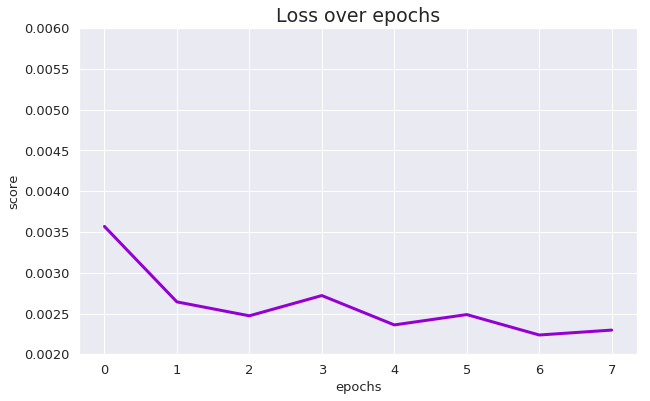

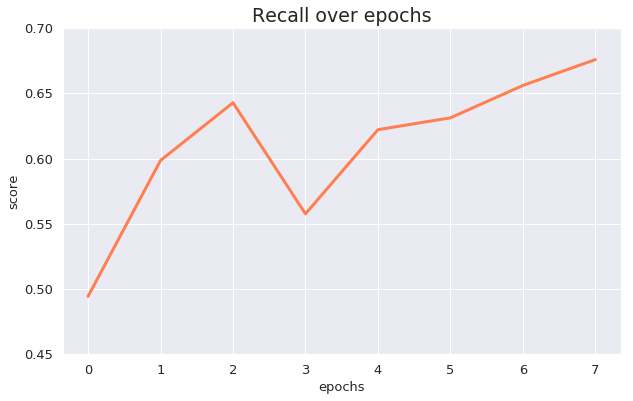

In [96]:
# Loss plot
fig_loss_2 = plt.figure(figsize=(10,6))
plt.plot(history_2.history['val_loss'], linewidth=3,
                      label='loss', color='darkviolet')
plt.title('Loss over epochs')
plt.ylim(0.0020, 0.0060)
plt.ylabel('score')
plt.xlabel('epochs')
plt.show()
fig_loss_2.savefig('./nn_2_loss.png', dpi=200)

# Recall plot
fig_recall_2 = plt.figure(figsize=(10,6))
plt.plot(history_2.history['val_recall_1'], linewidth=3,
                        label='recall', color='coral')
plt.title('Recall over epochs')
plt.ylabel('score')
plt.ylim(0.45, 0.70)
plt.xlabel('epochs')
plt.show()
fig_recall_2.savefig('./nn_2_recall.png', dpi=200)

In [99]:
# Generate predicted y values
y_prediction_nn_2 = nn_model_2.predict(X_test)

Area Under Curve: 0.9953717532702768


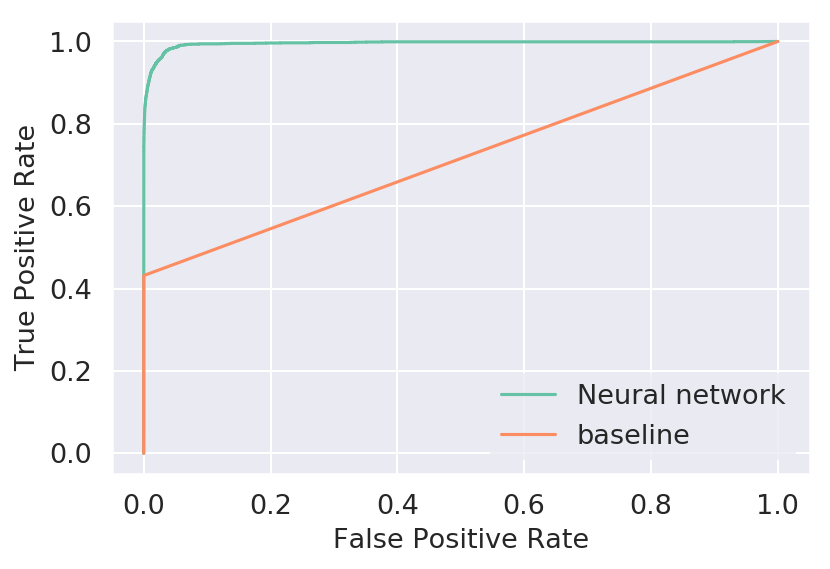

In [102]:
# Print the auc score
print(f'Area Under Curve: {roc_auc_score(y_test, y_prediction_nn_2)}')

# Plot roc_curve
fpr_nn_2, tpr_nn_2, _ = roc_curve(y_test, y_prediction_nn_2)

plt.plot(fpr_nn_2, tpr_nn_2, label='Neural network')
plt.plot(fpr_base, tpr_base, label='baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()